In [1]:
# reference : https://jaehyeongan.github.io/2020/02/29/LSTM-Autoencoder-for-Anomaly-Detection/


import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics


Bad key "text.kerning_factor" on line 4 in
C:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
labels_1 = ['Normal', 'Break']

In [3]:
df = pd.read_csv('./data/processminer-rare-event-mts-csv.csv')
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [4]:
Counter(df['y'])

Counter({0: 18274, 1: 124})

In [5]:
sign = lambda x: (1,-1)[x < 0]

In [6]:
sign

<function __main__.<lambda>(x)>

In [9]:
def curve_shift(df, shift_by):
    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)

    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)

    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})

    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [10]:
shifted_df = curve_shift(df, shift_by = -5)
shifted_df.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,0.0,5/1/99 0:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,0.0,5/1/99 0:02,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,0.0,5/1/99 0:04,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,0.0,5/1/99 0:06,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,0.0,5/1/99 0:08,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [11]:
shifted_df.isna().sum()

y       0
time    0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
x61     0
Length: 63, dtype: int64

In [16]:
for i in shifted_df.columns:
    
    
    print(i, len(shifted_df[i].value_counts()))

y 2
time 18274
x1 13995
x2 15665
x3 16507
x4 17486
x5 15797
x6 18129
x7 2006
x8 1423
x9 2899
x10 2350
x11 15360
x12 14468
x13 16982
x14 1616
x15 16177
x16 13607
x17 12810
x18 12550
x19 5760
x20 3435
x21 3679
x22 9159
x23 9272
x24 9347
x25 10815
x26 17491
x27 16991
x28 8
x29 15854
x30 14853
x31 12491
x32 11517
x33 1880
x34 17957
x35 10639
x36 2495
x37 2483
x38 3314
x39 3508
x40 145
x41 15644
x42 16390
x43 1200
x44 17809
x45 14999
x46 6958
x47 17879
x48 12729
x49 17778
x50 10728
x51 2722
x52 11172
x53 10863
x54 15979
x55 17449
x56 17777
x57 1105
x58 12954
x59 12161
x60 10758
x61 1


In [17]:
# drop remove columns
shifted_df = shifted_df.drop(['time','x28','x61'], axis=1)

# x, y
input_x = shifted_df.drop('y', axis=1).values
input_y = shifted_df['y'].values

n_features = input_x.shape[1]

In [18]:
n_features

59

In [19]:
shifted_df.shape

(18274, 60)

In [21]:
input_x.shape

(18274, 59)

In [22]:
input_y.shape

(18274,)

In [23]:
def temporalize(X, y, timesteps):
    
    output_X = []
    output_y = []
    
    for i in range(len(X)-timesteps -1):
        
        t = []
        
        for j in range(1, timesteps +1):
            
            t.append(X[[(i+j+1)], :])
            
        output_X.append(t)
        output_y.append(y[i+timesteps+1])
        
        
    return np.squeeze(np.array(output_X)), np.array(output_y)
    
    

In [24]:
timesteps = 5

# Temporalize
x, y = temporalize(input_x, input_y, timesteps)
print(x.shape) # (18268, 5, 59)

(18268, 5, 59)


In [25]:
# Split into train, valid, and test 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train,
                                                      y_train,
                                                      test_size=0.2)



In [26]:
print(len(x_train))  # 11691
print(len(x_valid))  # 2923
print(len(x_test))   # 3654

11691
2923
3654


In [27]:
x_train_y0 = x_train[y_train == 0]
x_train_y1 = x_train[y_train == 1]

x_valid_y0 = x_valid[y_valid == 0]
x_valid_y1 = x_valid[y_valid == 1]

In [33]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [34]:
def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [35]:
scaler = StandardScaler().fit(flatten(x_train_y0))

In [39]:
x_train_y0_scaled = scale(x_train_y0, scaler)
x_valid_scaled = scale(x_valid, scaler)
x_valid_y0_scaled = scale(x_valid_y0, scaler)
x_test_scaled = scale(x_test, scaler)

In [36]:
epochs = 200
batch = 128
lr = 0.001

In [48]:
lstm_ae = models.Sequential()

# Encoder
lstm_ae.add(layers.LSTM(32, activation='relu', 
                        input_shape=(timesteps, n_features), 
                        return_sequences=True))
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=False))
lstm_ae.add(layers.RepeatVector(timesteps))

# Decoder
lstm_ae.add(layers.LSTM(16, activation='relu', return_sequences=True))
lstm_ae.add(layers.LSTM(32, activation='relu', return_sequences=True))
lstm_ae.add(layers.TimeDistributed(layers.Dense(n_features)))

lstm_ae.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 32)             11776     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 59)             1947      
Total params: 25,243
Trainable params: 25,243
Non-trainable params: 0
__________________________________________________

In [49]:
# compile
lstm_ae.compile(loss='mse', optimizer=optimizers.Adam(lr))

# fit
history = lstm_ae.fit(x_train_y0_scaled, x_train_y0_scaled,
                     epochs=epochs, batch_size=batch,
                     validation_data=(x_valid_y0_scaled, x_valid_y0_scaled))


Epoch 1/200
89/89 [==============================] - 1s 14ms/step - loss: 0.8783 - val_loss: 0.6820
Epoch 2/200
89/89 [==============================] - 1s 7ms/step - loss: 0.5628 - val_loss: 0.4673
Epoch 3/200
89/89 [==============================] - 1s 7ms/step - loss: 0.4226 - val_loss: 0.3685
Epoch 4/200
89/89 [==============================] - 1s 8ms/step - loss: 0.3419 - val_loss: 0.3110
Epoch 5/200
89/89 [==============================] - 1s 10ms/step - loss: 0.2970 - val_loss: 0.2767
Epoch 6/200
89/89 [==============================] - 1s 8ms/step - loss: 0.2715 - val_loss: 0.2616
Epoch 7/200
89/89 [==============================] - 1s 7ms/step - loss: 0.2556 - val_loss: 0.2455
Epoch 8/200
89/89 [==============================] - 1s 8ms/step - loss: 0.2429 - val_loss: 0.2358
Epoch 9/200
89/89 [==============================] - 1s 8ms/step - loss: 0.2340 - val_loss: 0.2267
Epoch 10/200
89/89 [==============================] - 1s 8ms/step - loss: 0.2256 - val_loss: 0.2220
Epoch 1

Epoch 83/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1370 - val_loss: 0.1450
Epoch 84/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1388 - val_loss: 0.1515
Epoch 85/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1390 - val_loss: 0.1493
Epoch 86/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1374 - val_loss: 0.1443
Epoch 87/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1374 - val_loss: 0.1521
Epoch 88/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1391 - val_loss: 0.1453
Epoch 89/200
89/89 [==============================] - 1s 9ms/step - loss: 0.1379 - val_loss: 0.1453
Epoch 90/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1372 - val_loss: 0.1438
Epoch 91/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1387 - val_loss: 0.1463
Epoch 92/200
89/89 [==============================] - 1s 9ms/step - loss: 0.1385 - val_loss: 0.1500


89/89 [==============================] - 1s 8ms/step - loss: 0.1258 - val_loss: 0.1335
Epoch 165/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1256 - val_loss: 0.1342
Epoch 166/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1260 - val_loss: 0.1346
Epoch 167/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1263 - val_loss: 0.1347
Epoch 168/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1258 - val_loss: 0.1332
Epoch 169/200
89/89 [==============================] - 1s 7ms/step - loss: 0.1257 - val_loss: 0.1352
Epoch 170/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1254 - val_loss: 0.1356
Epoch 171/200
89/89 [==============================] - 1s 9ms/step - loss: 0.1251 - val_loss: 0.1351
Epoch 172/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1259 - val_loss: 0.1356
Epoch 173/200
89/89 [==============================] - 1s 8ms/step - loss: 0.1269 - val_loss: 0.1349
Epoc

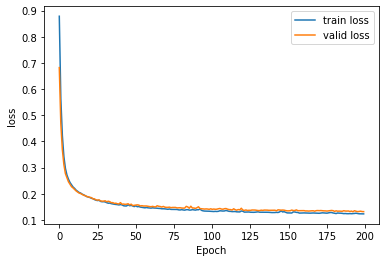

In [50]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [51]:
valid_x_predictions = lstm_ae.predict(x_valid_scaled)
mse = np.mean(np.power(flatten(x_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error':mse, 
                         'True_class':list(y_valid)})
precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], 
                                                                       error_df['Reconstruction_error'])

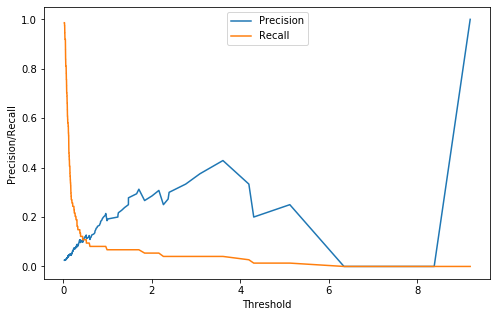

In [52]:
plt.figure(figsize=(8,5))
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [53]:
# best position of threshold
index_cnt = [cnt for cnt, (p, r) in enumerate(zip(precision_rt, recall_rt)) if p==r][0]
print('precision: ',precision_rt[index_cnt],', recall: ',recall_rt[index_cnt])

# fixed Threshold
threshold_fixed = threshold_rt[index_cnt]
print('threshold: ',threshold_fixed)

precision:  0.10810810810810811 , recall:  0.10810810810810811
threshold:  0.46123647810556034


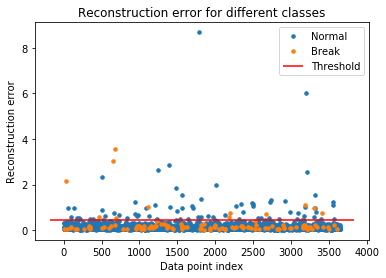

In [54]:
test_x_predictions = lstm_ae.predict(x_test_scaled)
mse = np.mean(np.power(flatten(x_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

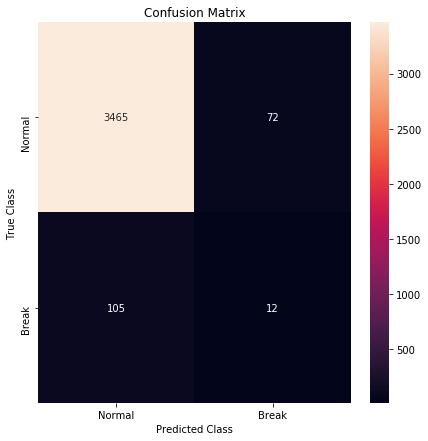

In [58]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]

conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=labels_1, yticklabels=labels_1, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

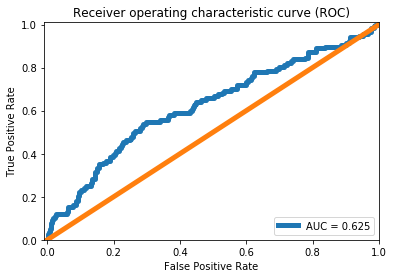

In [59]:
false_pos_rate, true_pos_rate, thresholds = metrics.roc_curve(error_df['True_class'], error_df['Reconstruction_error'])
roc_auc = metrics.auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.show()